# **Data Modelling**

Once we clean the data and have a breif exploratory analysis on the data we will now model it to get the right inferences. Our goal was to find the location of properties which suitable for real estate investment and which will give us high return in the future.

Any real estate property cannot alone withstand based on the features it provides like 2 bedrooms , 3 bathrooms but the accessibility of that location with nearby amenities.

Hence we will consider such amenities in our modeling to find out the best locations for purchasing a real estate property. The amenities are as follows: 

*   Groceries
*   Restaurants
*   Hospitals
*   Bars
*   Fuel stations
*   Public_transport
*   Parks
*   Schools

The shortest distance from nearby amenities will be calculated and added to the data.

##### **Install and Import Libraries**

In [ ]:
#Install libraries
!apt install python3-rtree --quiet
!pip install osmnx
!pip install geopandas

In [ ]:
#Import libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import osmnx as ox
ox.config(log_console=True, use_cache=True)
import folium
from shapely.geometry import box

##### **Read sample data as spatial data**

In [ ]:
sample_df = pd.read_csv('content/sample_houses.csv')
sample_gdf = gpd.GeoDataFrame(sample_df,crs='epsg:4326', geometry=gpd.points_from_xy(x=sample_df.LONGITUDE, y=sample_df.LATITUDE)) 
sample_gdf.head(5)

,SALE TYPE,PROPERTY TYPE,ADDRESS,CITY,STATE OR PROVINCE,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,LOCATION,SQUARE FEET,LOT SIZE,YEAR BUILT,DAYS ON MARKET,DOLLAR PER SQFT,HOA PER MONTH,STATUS,URL,SOURCE,MSL,LATITUDE,LONGITUDE,geometry
0,MLS Listing,Townhouse,6813 NW 163rd Ave,Portland,OR,97229,535000,4,2.5,Arbor Lakes,1922,2613,2014,2,278,212,Active,http://www.redfin.com/OR/Portland/6813-NW-163r...,RMLS,21056418,45.568689,-122.845517,POINT (-122.84552 45.56869)
1,PAST SALE,Single Family Residential,2525 NW Arnott Ln,Portland,OR,97229,629900,4,2.5,IRON RIDGE PARK,2324,4791,2011,318,271,30,Sold,http://www.redfin.com/OR/Portland/2525-NW-Arno...,RMLS,20264930,45.537885,-122.795329,POINT (-122.79533 45.53789)
2,PAST SALE,Single Family Residential,4561 NW Continental Pl,Beaverton,OR,97006,450000,3,2.5,NW Washington Co or Sauvie Island,1518,2613,2000,183,296,75,Sold,http://www.redfin.com/OR/Beaverton/4561-NW-Con...,RMLS,21067322,45.552849,-122.850795,POINT (-122.85079 45.55285)
3,PAST SALE,Single Family Residential,1123 NW 93rd Ave,Portland,OR,97229,490000,4,2.5,NW Washington Co or Sauvie Island,1853,3049,2011,1534,264,48,Sold,http://www.redfin.com/OR/Portland/1123-NW-93rd...,RMLS,17684940,45.527355,-122.773088,POINT (-122.77309 45.52736)
4,PAST SALE,Single Family Residential,12781 NW Forest Spring Ln,Portland,OR,97229,590000,4,2.5,BAUER HIGHLANDS,2416,4356,2001,1123,244,20,Sold,http://www.redfin.com/OR/Portland/12781-NW-For...,RMLS,18208993,45.550917,-122.808786,POINT (-122.80879 45.55092)


##### **Add columns**
Create columns for adding distance from amenities

In [ ]:
sample_gdf['Groceries'] = ''
sample_gdf['Restaurants']  = ''
sample_gdf['Hospitals'] = ''
sample_gdf['Bars'] = ''
sample_gdf['Fuel stations'] = ''
sample_gdf['Public_transport'] = ''
sample_gdf['Parks'] = ''
sample_gdf['Schools'] = ''

##### **Fetch all nearby amenities** 


In [ ]:
#Intiate the columns with 0 value
sample_gdf['Groceries'] = 0
sample_gdf['Restaurants']  = 0
sample_gdf['Hospitals'] = 0
sample_gdf['Bars'] = 0
sample_gdf['Fuel stations'] = 0
sample_gdf['Public_transport'] = 0
sample_gdf['Parks'] = 0
sample_gdf['Schools'] = 0

In [ ]:
%%time

# get bounding box of the data and then find a centroid for that geometry
xmin, ymin, xmax, ymax = sample_gdf.total_bounds
geom = box(xmin, ymin, xmax, ymax)

# Put the centroid as input and have 50000 metres i.e 50km and extract all data defined in tags
tags = { "highway": "bus_stop","leisure": ["garden","park"], "amenity": ["bar", "restaurant","school", "fuel", "hospital","marketplace"],"shop":"supermarket"}
osm_geoms = ox.geometries_from_point((geom.centroid.y,geom.centroid.x), tags, dist=50000) #distance is specified as 50000metres i.e 50km

# Reprject the layers so that we can create buffer along the point and the same projection would be there while applying intersection operations
osm_geoms = osm_geoms.to_crs('epsg:3857')
sample_gdf = sample_gdf.to_crs('epsg:3857')

for idx,rows in sample_gdf.iterrows():
  cur_point = rows['geometry'].buffer(10000) # create buffer of 10km as it would take a car 15mins to cover a distance of 10km at the average speed of 40km/hr

  # Now we will query specific tags and intersect it with the buffer of the house coordinate to get all nearby amenities
  transport_gdf = osm_geoms.query('highway == "bus_stop"')
  transport_gdf = transport_gdf.query('highway == "bus_stop"')[transport_gdf.query('highway == "bus_stop"').intersects(cur_point)]
  sample_gdf.at[idx,'Public_transport'] = transport_gdf.shape[0]

  park_gdf = osm_geoms.query('leisure == "garden" | leisure == "park" ')
  park_gdf = park_gdf.query('leisure == "garden" | leisure == "park" ')[park_gdf.query('leisure == "garden" | leisure == "park" ').intersects(cur_point)]
  sample_gdf.at[idx,'Parks'] = park_gdf.shape[0]

  bars_gdf = osm_geoms.query('amenity == "bar"')
  bars_gdf = bars_gdf.query('amenity == "bar"')[bars_gdf.query('amenity == "bar"').intersects(cur_point)]
  sample_gdf.at[idx,'Bars'] = bars_gdf.shape[0] 

  restaurant_gdf = osm_geoms.query('amenity == "restaurant"')
  restaurant_gdf = restaurant_gdf.query('amenity == "restaurant"')[restaurant_gdf.query('amenity == "restaurant"').intersects(cur_point)]
  sample_gdf.at[idx,'Restaurants'] = restaurant_gdf.shape[0]

  school_gdf = osm_geoms.query('amenity == "school"')
  school_gdf = school_gdf.query('amenity == "school"')[school_gdf.query('amenity == "school"').intersects(cur_point)]
  sample_gdf.at[idx,'Schools'] = school_gdf.shape[0]

  fuel_gdf = osm_geoms.query('amenity == "fuel"')
  fuel_gdf = fuel_gdf.query('amenity == "fuel"')[fuel_gdf.query('amenity == "fuel"').intersects(cur_point)]
  sample_gdf.at[idx,'Fuel stations'] = fuel_gdf.shape[0]

  hospital_gdf = osm_geoms.query('amenity == "hospital"')
  hospital_gdf = hospital_gdf.query('amenity == "hospital"')[hospital_gdf.query('amenity == "hospital"').intersects(cur_point)]
  sample_gdf.at[idx,'Hospitals'] = hospital_gdf.shape[0]

  marketplace_gdf = osm_geoms.query('amenity == "marketplace" | shop == "supermarket"')
  marketplace_gdf = marketplace_gdf.query('amenity == "marketplace" | shop == "supermarket"')[marketplace_gdf.query('amenity == "marketplace" | shop == "supermarket"').intersects(cur_point)]
  sample_gdf.at[idx,'Groceries'] = marketplace_gdf.shape[0]

  print('index being processed is ',idx)

##### **Visualize the quantitative data**

Let's have a look on the histogram of the data we extracted

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


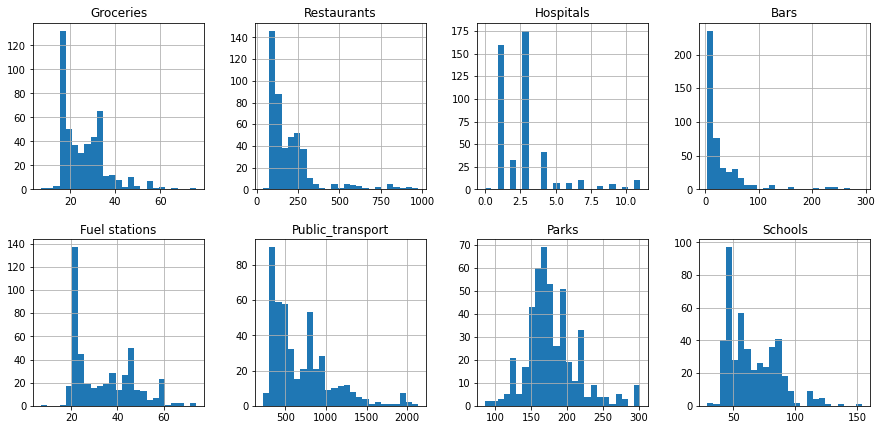

In [ ]:
hist_plot = sample_gdf[['Groceries','Restaurants','Hospitals','Bars','Fuel stations','Public_transport','Parks','Schools']].hist(bins=25, layout=(4,4), figsize=(15,15))

##### **Save to disk**

In [ ]:
sample_gdf.to_csv('houses_features.csv',index=False)
sample_gdf.to_file('houses_features.geojson',driver='GeoJSON')